In [1]:
#!pip install nibabel tqdm scikit-image

In [2]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [3]:
#데이터 셋 가져오기
def get_mask_data():

    x_train_path = "dataset/Image_Segmentation/x_train2.npy"
    x_val_path = "dataset/Image_Segmentation/x_val2.npy" 
    y_train_path = "dataset/Image_Segmentation/y_train2.npy"
    y_val_path = "dataset/Image_Segmentation/y_val2.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    
        
    return x_train, y_train, x_val, y_val


In [4]:
# CNN 인 VGG16 U-net
def VGG16_Unet(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16       #feature map 수
    kernel_size = 3    # kernel size
    copy_layers = []   # Encoder에 있는 Activation map을 저장하는 리스트
    net = inputs
  
    #Encoder1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #첫번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder2 
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #두번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder3
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #세번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder4
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #네번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #Encoder5
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #다섯번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    
    #Decoder : upsampling
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #다섯번째 Activation map 
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #네번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #세번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #두번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #첫번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(2, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                  metrics=['acc',tf.keras.metrics.MeanIoU(num_classes=2)])

    model.summary()
    
    
    

    return model

In [5]:
def Unet(x_train, y_train, x_val, y_val) :
    
    inputs = Input(shape=(256, 256, 1))
    
    f = 16
    layers = []
    net = inputs
  
    for i in range(0, 6):
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        layers.append(net)
        net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
        f = f*2
        #512
    ff2 = 256
  
    #bottleneck 
    j = len(layers) - 1
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, layers[j]])
    j = j -1 
  
    #upsampling 
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        print(net.shape)
        net = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (net)
        print(net.shape)
        net = Concatenate(axis=3)([net, layers[j]])
        j = j -1 
    
  
    #classification 
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    outputs = Conv2D(2, 1, activation='sigmoid') (net)


    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['acc', 'mse', tf.keras.metrics.MeanIoU(num_classes=2)])
    model.summary()
    
    return model

In [6]:
def training(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    
    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')
    

#     preds = model.predict(x_val)
#     fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
#     temp = np.empty((256, 256, 1), dtype=np.float32)

#     for i in range(40):
#         ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
#         ax[i, 0].title.set_text(str(i))
    
#         y_val_0 = y_val[...,0]
#         ax[i, 1].imshow(y_val_0[i].squeeze(), cmap='gray')
    
#         predict_0 = preds[...,0]
#         ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
    
#         temp = x_val[i]
#         pred_sum = predict_0[i][predict_0[i] > 0]
#         pred_mean = np.mean(predict_0)
#         if(np.min(temp) >= 0) :
#             temp[predict_0[i] < 0.5] = 0
#         else :
#             temp[predict_0[i] < 0.5] = -2048
#         ax[i, 3].imshow(temp.squeeze(), cmap='gray')


In [7]:
x_train, y_train, x_val, y_val = get_mask_data()
print(y_train.max(), y_train.min())
print(x_train.max(), x_train.min())
print(x_val.max(), x_val.min())
# model = VGG16_Unet(x_train, y_train2, x_val, y_val2)
# history = training(model,x_train, y_train2, x_val, y_val2)

(2675, 256, 256, 1) (2675, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)
1 0
1.0 0.0
1.0 0.0


(None, 8, 8, 512)
(None, 16, 16, 128)
(None, 16, 16, 256)
(None, 32, 32, 64)
(None, 32, 32, 128)
(None, 64, 64, 32)
(None, 64, 64, 64)
(None, 128, 128, 16)
(None, 128, 128, 32)
(None, 256, 256, 8)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
_______________________________________________________________________________________________

Epoch 1/30
168/168 [==============================] - 100s 505ms/step - loss: 0.2863 - acc: 0.8611 - mse: 0.0917 - mean_io_u: 0.2656 - val_loss: 0.1901 - val_acc: 0.8883 - val_mse: 0.0583 - val_mean_io_u: 0.4228
Epoch 2/30
168/168 [==============================] - 78s 462ms/step - loss: 0.0895 - acc: 0.9671 - mse: 0.0253 - mean_io_u: 0.4669 - val_loss: 0.0378 - val_acc: 0.9873 - val_mse: 0.0098 - val_mean_io_u: 0.5545
Epoch 3/30
168/168 [==============================] - 78s 462ms/step - loss: 0.0315 - acc: 0.9894 - mse: 0.0083 - mean_io_u: 0.5810 - val_loss: 0.0290 - val_acc: 0.9901 - val_mse: 0.0077 - val_mean_io_u: 0.5504
Epoch 4/30
168/168 [==============================] - 77s 461ms/step - loss: 0.0242 - acc: 0.9916 - mse: 0.0065 - mean_io_u: 0.5865 - val_loss: 0.0226 - val_acc: 0.9924 - val_mse: 0.0059 - val_mean_io_u: 0.5827
Epoch 5/30
168/168 [==============================] - 78s 462ms/step - loss: 0.0195 - acc: 0.9931 - mse: 0.0053 - mean_io_u: 0.5926 - val_loss: 0.0187 - va

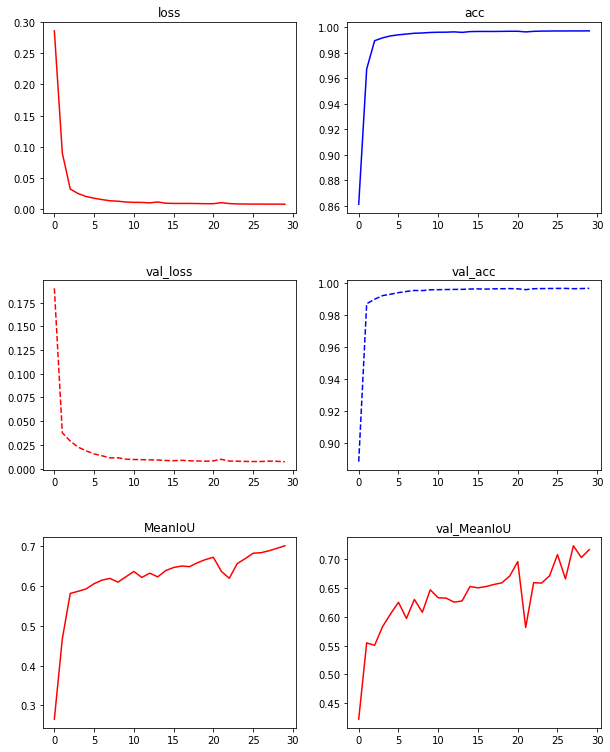

In [8]:
model = Unet(x_train, y_train, x_val, y_val)
history = training(model,x_train, y_train, x_val, y_val)

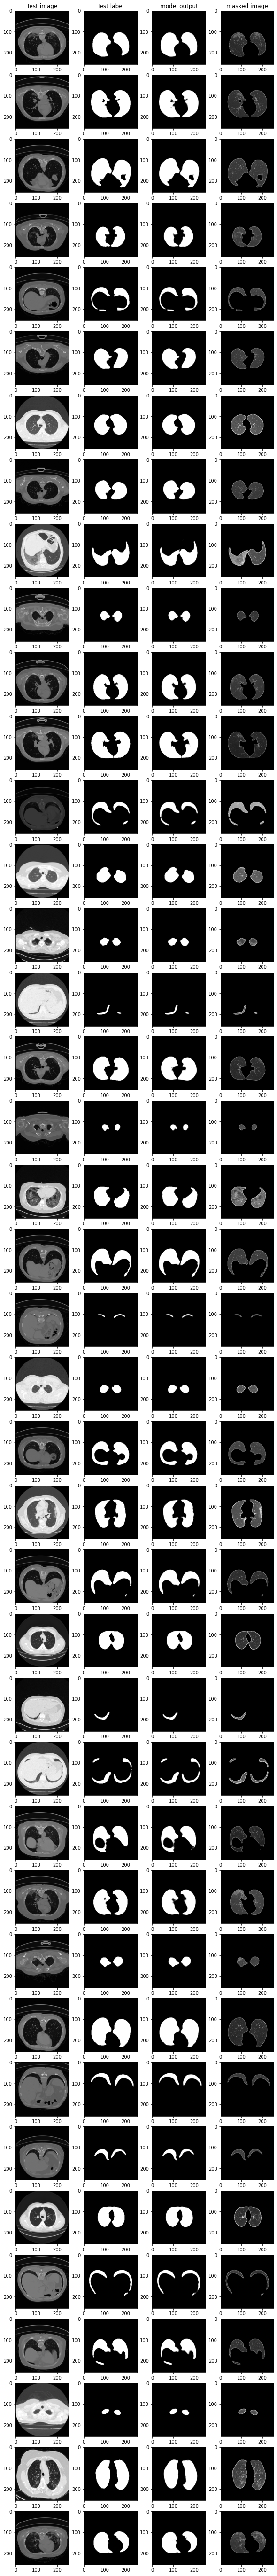

In [9]:
preds = model.predict(x_val)
fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 1), dtype=np.float32)

ax[0, 0].title.set_text("Test image")
ax[0, 1].title.set_text("Test label")
ax[0, 2].title.set_text("model output")
ax[0, 3].title.set_text("masked image")
for i in range(40):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    
    y_val_0 = y_val[...,0]
    ax[i, 1].imshow(y_val_0[i].squeeze(), cmap='gray')
    
    predict_0 = preds[...,0]
    ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
    
    temp = x_val[i]
    pred_sum = predict_0[i][predict_0[i] > 0]
    pred_mean = np.mean(predict_0)
    temp[predict_0[i] < 0.5] = 0
    ax[i, 3].imshow(temp.squeeze(), cmap='gray')
    

In [10]:
y_val_com_0 = y_val[...,0] #image label 
predict_com_0 = preds[...,0] #prediction (model output)

IOU_SUM = 0.0
IOU_AVE = 0.0
Number_image =0

for n,_ in enumerate(y_val_com_0) :
    
    TP = 0
    NP = 0
    index = n
    
    y_label_image = y_val_com_0[index].copy()
    predict_image = predict_com_0[index].copy()

    #model output 0번째 사진의 각 픽셀에 0.5보다 작으면 0 크면 1
    predict_image[predict_image < 0.5] = 0 
    predict_image[predict_image > 0.5] = 1

    #비교 해서 같으면 TP+1 아니면 NP+1
    for i in range(256) :
        for j in range(256) :
            if(y_label_image[i][j] == predict_image[i][j]) :
                TP = TP + 1
            else :
                NP = NP + 1

    print('Number : ', n, 'TP :', TP,'NP : ', NP)
    print('IOU :', TP/ (TP + NP) , '\n')
    IOU_SUM = TP/ (TP + NP) + IOU_SUM
    Number_image = n
    
IOU_AVE = IOU_SUM / (Number_image +  1)
print("IOU_AVE : ", IOU_AVE)


Number :  0 TP : 65348 NP :  188
IOU : 0.99713134765625 

Number :  1 TP : 65320 NP :  216
IOU : 0.9967041015625 

Number :  2 TP : 65174 NP :  362
IOU : 0.994476318359375 

Number :  3 TP : 65384 NP :  152
IOU : 0.9976806640625 

Number :  4 TP : 65367 NP :  169
IOU : 0.9974212646484375 

Number :  5 TP : 65387 NP :  149
IOU : 0.9977264404296875 

Number :  6 TP : 65446 NP :  90
IOU : 0.998626708984375 

Number :  7 TP : 65440 NP :  96
IOU : 0.99853515625 

Number :  8 TP : 65257 NP :  279
IOU : 0.9957427978515625 

Number :  9 TP : 65454 NP :  82
IOU : 0.998748779296875 

Number :  10 TP : 65354 NP :  182
IOU : 0.997222900390625 

Number :  11 TP : 65225 NP :  311
IOU : 0.9952545166015625 

Number :  12 TP : 65206 NP :  330
IOU : 0.994964599609375 

Number :  13 TP : 65389 NP :  147
IOU : 0.9977569580078125 

Number :  14 TP : 65395 NP :  141
IOU : 0.9978485107421875 

Number :  15 TP : 65478 NP :  58
IOU : 0.999114990234375 

Number :  16 TP : 65383 NP :  153
IOU : 0.997665405273437

Number :  137 TP : 65459 NP :  77
IOU : 0.9988250732421875 

Number :  138 TP : 65514 NP :  22
IOU : 0.999664306640625 

Number :  139 TP : 65479 NP :  57
IOU : 0.9991302490234375 

Number :  140 TP : 65288 NP :  248
IOU : 0.9962158203125 

Number :  141 TP : 65250 NP :  286
IOU : 0.995635986328125 

Number :  142 TP : 65455 NP :  81
IOU : 0.9987640380859375 

Number :  143 TP : 65222 NP :  314
IOU : 0.995208740234375 

Number :  144 TP : 65271 NP :  265
IOU : 0.9959564208984375 

Number :  145 TP : 65399 NP :  137
IOU : 0.9979095458984375 

Number :  146 TP : 65262 NP :  274
IOU : 0.995819091796875 

Number :  147 TP : 65291 NP :  245
IOU : 0.9962615966796875 

Number :  148 TP : 65457 NP :  79
IOU : 0.9987945556640625 

Number :  149 TP : 65507 NP :  29
IOU : 0.9995574951171875 

Number :  150 TP : 65314 NP :  222
IOU : 0.996612548828125 

Number :  151 TP : 65393 NP :  143
IOU : 0.9978179931640625 

Number :  152 TP : 65406 NP :  130
IOU : 0.998016357421875 

Number :  153 TP : 6543

Number :  272 TP : 65352 NP :  184
IOU : 0.9971923828125 

Number :  273 TP : 65336 NP :  200
IOU : 0.9969482421875 

Number :  274 TP : 65444 NP :  92
IOU : 0.99859619140625 

Number :  275 TP : 65369 NP :  167
IOU : 0.9974517822265625 

Number :  276 TP : 65408 NP :  128
IOU : 0.998046875 

Number :  277 TP : 65459 NP :  77
IOU : 0.9988250732421875 

Number :  278 TP : 65292 NP :  244
IOU : 0.99627685546875 

Number :  279 TP : 65381 NP :  155
IOU : 0.9976348876953125 

Number :  280 TP : 65450 NP :  86
IOU : 0.998687744140625 

Number :  281 TP : 65137 NP :  399
IOU : 0.9939117431640625 

Number :  282 TP : 65292 NP :  244
IOU : 0.99627685546875 

Number :  283 TP : 65260 NP :  276
IOU : 0.99578857421875 

Number :  284 TP : 65295 NP :  241
IOU : 0.9963226318359375 

Number :  285 TP : 65168 NP :  368
IOU : 0.994384765625 

Number :  286 TP : 65326 NP :  210
IOU : 0.996795654296875 

Number :  287 TP : 65277 NP :  259
IOU : 0.9960479736328125 

Number :  288 TP : 64948 NP :  588
IOU